In [1]:
import os
from pynq import Overlay
from pynq import MMIO
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

In [2]:
# FIRMWARE UPLOAD
firmware = Overlay("single_chan_v6.bit",ignore_version=True)

# INITIALIZING LMK04208 CLOCK
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [3]:
lofreq = 1000.000 # [MHz]
rf_data_conv = firmware.usp_rf_data_converter_0
rf_data_conv.adc_tiles[0].blocks[0].MixerSettings['Freq']=lofreq
rf_data_conv.dac_tiles[1].blocks[3].MixerSettings['Freq']=lofreq
rf_data_conv.adc_tiles[0].blocks[0].UpdateEvent(xrfdc.EVENT_MIXER)
rf_data_conv.dac_tiles[1].blocks[3].UpdateEvent(xrfdc.EVENT_MIXER)

In [4]:
########################3
# Configure udp ip and mac
##########################
dst_mac_reg = firmware.eth_wrap.IP_MAC_gpio_hier.dst_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
src_mac_reg = firmware.eth_wrap.IP_MAC_gpio_hier.src_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
ip_reg = firmware.eth_wrap.IP_MAC_gpio_hier.ip # offset 0x00 src ip, offset 0x08 dst ip
eth_delay_reg = firmware.eth_wrap.eth_delay # programmable delay for eth byte shift
data_in_mux = firmware.eth_wrap.data_in_mux
# setting ips
src_ip_int32 = int("c0a80329",16)
dst_ip_int32 = int("c0a80328",16)
src_mac0_int32 = int("deadbeef",16)
src_mac1_int16 = int("feed",16)
dst_mac0_int32 = int("5d092bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
dst_mac1_int16 = int("803f",16)

# write values
ip_reg.write( 0x00, src_ip_int32) 
ip_reg.write( 0x08, dst_ip_int32)
dst_mac_reg.write( 0x00, dst_mac0_int32)
dst_mac_reg.write( 0x08, dst_mac1_int16)
src_mac_reg.write( 0x00, src_mac0_int32)
src_mac_reg.write( 0x08, src_mac1_int16)

In [5]:
###############################
# Ethernet Delay Lines  
###############################
eth_delay_reg.write(0x00, 20 + (4<<16))#44 + (4<<16)) # data output from eth buffer delay/ input to eth buffer delay <<16 delay
eth_delay_reg.write(0x08, 3) # start pulse out delay
###############################
# Data MUX
###############################
data_in_mux.write( 0x00, 1) # coffee when 0, data when 1
data_in_mux.write( 0x08, (509) + ((8189)<<16) ) # ethernet max write count and max read count
###############################
# DDC shift
###############################

#dds_shift.write(0x00dds_shift.write(0x00,12) # 100 : for each addr in ddc bin list, 25 for bin list offs 50

# Generating DDS/DAC Waveform

In [6]:
def phase_shift(ts, phase):
    y = ts*np.exp(1j*phase)
    return ts.real + 1j*y.imag

def norm_wave(ts, max_amp=2**15-1):
    """
     Re-configure generated data values to fit LUT
    """
    Imax = max(abs(ts.real))
    Qmax = max(abs(ts.imag))
    norm = max(abs(ts))
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freq_list: np.array
            list of tones to generate [Hz]
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=18   # address bit width
    channels= 2    # data points per memory address for DAC
    fs = 1024e6    # sampling rate of D/A, FPGA fabric = fs/2
    C=2            # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      #freqs = -1*C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
      freqs_up = 1*C*np.linspace(-251e6,-1e6, N//2)
      freqs_lw = 1*C*np.linspace(2.15e6,252.15e6,N//2)
      freqs = np.append(freqs_up,freqs_lw)
      #freqs = freqs_up
    else:
      freqs = C*freq_list # equally spaced tones
    phases = np.random.uniform(-np.pi,np.pi,len(freqs))
    #phases[0] = 2*2np.arctan2(6e14,2e10)

    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/data_p # Hz
    fftbin_bw = 500e3 # Hz for effective bandwidth of 512MHz/1024 point fft on adc
    print(freq_res)
    
    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res
    print("{} Frequencies Generated:".format(len(freqs)))
    print(freqs/C*1e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    fft_bin_nums=np.zeros(len(freqs),dtype=int) # array of all dac bin index
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        fft_bin_nums[i]=(np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C
        #print("lutwaveformflist{}".format((np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C))
        #print(fft_bin_nums[i])
        delta[bin_num] = np.exp(1j*phases[i]) 
    ts = np.fft.ifft(delta)

    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    f_fft_bin = fft_bin_nums*fftbin_bw
    f_beat = (freqs/C - f_fft_bin/C)
    
    if verbose:
        print("\nBeat Frequencies:")
        print(f_beat)
        print(freqs/C)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs),2**9), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs),2**9), dtype="complex")
    bin_num_ddc = np.round(f_beat*2/freq_res) # factor of 2 for half a bin width
    
    print("bin num ddc "+str(bin_num_ddc))

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = np.exp(-1j*phases[i])
        beat_ddc[i] = np.conj(np.fft.ifft(delta_ddc[i]))
        
    for i in range(1024):
        if (i<len(freqs)):
            wave_ddc[i::1024] = beat_ddc[i]
        else:
            wave_ddc[i::1024] = 0
    
    dacI, dacQ = norm_wave(ts)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**13)-1)
    return dacI, dacQ, ddcI, ddcQ, freqs

def load_DAC(wave_real, wave_imag):
    base_addr_DAC_I = 0x0400000000
    base_addr_DAC_Q = 0x0400100000
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DAC_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DAC_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(Q1) << 16) + I1).astype("int32")
    dataQ = ((np.int32(Q0) << 16) + I0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144]
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DAC waveform uploaded to AXI BRAM")
    return

def load_DDS(wave_real, wave_imag):
    
    base_addr_DDS_I = 0x0080000000
    base_addr_DDS_Q = 0x0080100000
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DDS_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DDS_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(I1) << 16) + I0).astype("int32")
    dataQ = ((np.int32(Q1) << 16) + Q0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144]
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DDC waveform uploaded to AXI BRAM")
    return

def load_bin_list(freqs):
    bin_list = np.int64( np.round(freqs/1e6) )
    print("bin_list:"+str(bin_list))
    # DSP REGS
    dsp_regs = firmware.dsp_regs_0
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    
    #fft_shift_and_load_bins = firmware.gpio1.axi_gpio_0 # 0x00 fft shift, 0x08 load bins
    #accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0-23 accum len, 24 accum rst, 25 sync in
    
    # mapping old to new gpios
    # bins -> bin_num
    
    # initialization 
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1
    ################################################
    # Load DDC bins
    ################################################
    offs=0
    
    # only write tones to bin list
    for addr in range(1024):
        if addr<(len(bin_list)):
            print("addr = {}, bin# = {}".format(addr, bin_list[addr]))
            #accum_and_bin_idx.write(0x00, int(bin_list[addr])) #110 # write bin for address single address
            dsp_regs.write(0x04,int(bin_list[addr]))
            #fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            #fft_shift_and_load_bins.write(0x08,0) # disable we
            dsp_regs.write(0x00, 0)
        else:
            #accum_and_bin_idx.write(0x00,0)#0) #110 # write bin for address single address
            dsp_regs.write(0x04,0)
            #fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            #fft_shift_and_load_bins.write(0x08,0) # disable we
            dsp_regs.write(0x00, 0)
    return

def load_waveform_into_mem(freqs, dac_r,dac_i,dds_r,dds_i):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    
    # Arming DDC Waveform
    ########################
    dsp_regs = firmware.dsp_regs_0
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    # initialization  
    sync_in = 2**26
    accum_rst = 2**24  # (active rising edge)
    accum_length = (2**19)-1 # (2**18)-1
    
    fft_shift=0
    if len(freqs)<400:
        fft_shift = 2**9-1
    else:
        fft_shift = 2**2-1
    
    #fft_shift_and_load_bins = firmware.gpio1.axi_gpio_0
    #dds_shift=firmware.gpio3.axi_gpio_0 # DDS SHIFT offset = 0x00, 0x08 is open
    #dds_shift.write(0x00,262)#234) # WRITING TO DDS SHIFT
    dsp_regs.write(0x0c,262)
    #accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0b-23b accum len, 24b accum rst, 26b sync in
    #accum_and_bin_idx.write(0x08,1*accum_length) #100
    dsp_regs.write(0x08,accum_length)
    
    # accum reset low then high
    #fft_shift_and_load_bins.write(0x00,2**11) # reset DAC/DDS counter
    dsp_regs.write(0x00, 2**11) # reset dac/dds counter
    dsp_regs.write(0x00, 0) # reset dac/dds counter
    dsp_regs.write(0x08,accum_length | accum_rst)

    #accum_and_bin_idx.write(0x08,1*accum_length+0*sync_in+1*accum_rst) # 101 
    #dsp_regs.write(0x08,accum_length | sync_in) # starts  
    
    load_DAC(dac_r,dac_i)
    load_DDS(dds_r,dds_i)
    sleep(.5)
    #fft_shift_and_load_bins.write(0x00, fft_shift+2**10) # enable DAC/DDS counter
    dsp_regs.write(0x00, fft_shift) # set fft shift
    ########################
    #accum_and_bin_idx.write(0x08,1*accum_length+1*sync_in+0*accum_rst) # 110 -- STARTS DSP FIRMWARE
    dsp_regs.write(0x08, accum_length | sync_in)
    sleep(0.5)
    #accum_and_bin_idx.write(0x08,1*accum_length+1*sync_in+1*accum_rst) #111
    dsp_regs.write(0x08, accum_length | accum_rst | sync_in)
   
    return 0

In [24]:
LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(20.2e6,50.0e6,5), vna=False, verbose=True)
load_bin_list(freqs)
load_waveform_into_mem(freqs, LUT_I, LUT_Q, DDS_I, DDS_Q)

1953.125
5 Frequencies Generated:
[20.20019531 27.65039062 35.09960938 42.54980469 50.        ]

Beat Frequencies:
[200195.3125 150390.625   99609.375   49804.6875      0.    ]
[20200195.3125 27650390.625  35099609.375  42549804.6875 50000000.    ]
bin num ddc [205. 154. 102.  51.   0.]
bin_list:[ 40  55  70  85 100]
addr = 0, bin# = 40
addr = 1, bin# = 55
addr = 2, bin# = 70
addr = 3, bin# = 85
addr = 4, bin# = 100
DAC waveform uploaded to AXI BRAM
DDC waveform uploaded to AXI BRAM


0

In [25]:
# WIDE BRAM

axi_wide = firmware.axi_wide_ctrl# 0x0 max count, 0x8 capture rising edge trigger
max_count = 32768
mux_sel = 3
axi_wide.write(0x08, mux_sel<<1) # mux select 0-adc, 1-pfb, 2-ddc, 3-accum
axi_wide.write(0x00, max_count - 16) # -4 to account for extra delay in write counter state machine
axi_wide.write(0x08, mux_sel<<1 | 0)
axi_wide.write(0x08, mux_sel<<1 | 1)
axi_wide.write(0x08, mux_sel<<1 | 0)
base_addr_wide = 0x00_A007_0000
mmio_wide_bram = MMIO(base_addr_wide,max_count)
wide_data = mmio_wide_bram.array[0:8192]# max/4, bram depth*word_bits/32bits
print(wide_data[0:32])

[660 180 0 4294967294 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


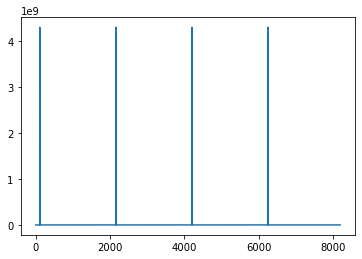

In [132]:
plt.plot(wide_data)

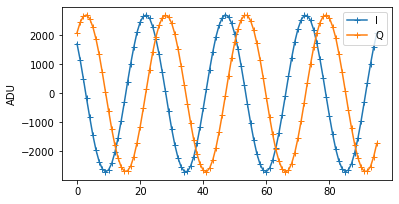

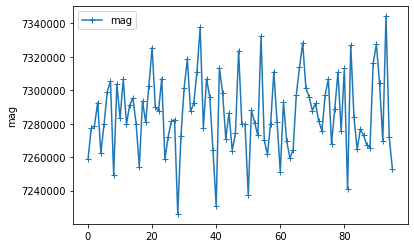

In [9]:
# parsing for ADC
up0, lw0 = np.int16(wide_data[0::4] >> 16), np.int16(wide_data[0::4] & 0x0000ffff)
up1, lw1 = np.int16(wide_data[1::4] >> 16), np.int16(wide_data[1::4] & 0x0000ffff)
I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = lw0
Q3[1::2] = up0
I3[0::2] = lw1
I3[1::2] = up1
plt.figure(figsize=(13,7))
c = slice(4000,4096)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.ylabel("mag")
plt.legend()

<Figure size 936x504 with 0 Axes>

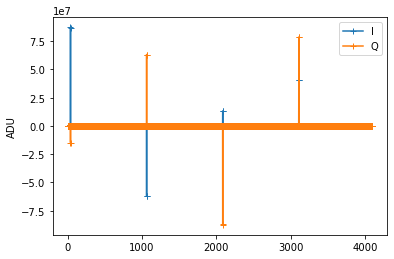

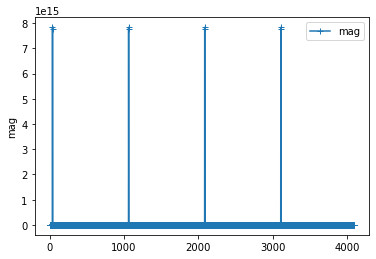

In [13]:
# parsing for PFB
chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
q0 = np.int64((chunk0 & 0x000000000003ffff)<<np.uint64(46))/2**32
i0 = np.int64(((chunk0>>18) & 0x000000000003ffff)<<np.uint64(46))/2**32
q1 = np.int64(((chunk1>>4)  & 0x000000000003ffff)<<np.uint64(46))/2**32
i1 = np.int64(((chunk1>>22)  & 0x000000000003ffff)<<np.uint64(46))/2**32

I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = q0
Q3[1::2] = q1
I3[0::2] = i0
I3[1::2] = i1
plt.figure(figsize=(13,7))
c = slice(0,4096)

plt.figure()
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.ylabel("mag")
plt.legend()

<Figure size 936x504 with 0 Axes>

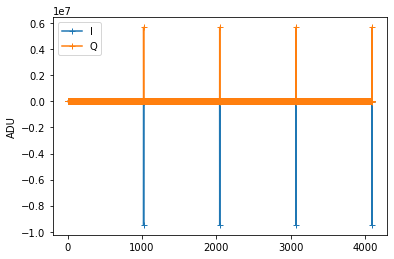

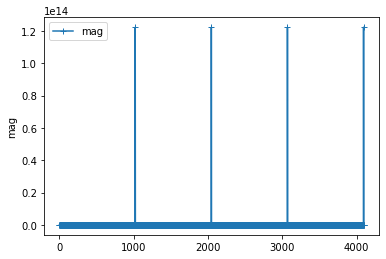

In [17]:
# parsing for DDC
chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
q0 = np.int64((chunk0 & 0x00000000000fffff)<<np.uint64(45))/2**32
i0 = np.int64(((chunk0>>19) & 0x00000000000fffff)<<np.uint64(45))/2**32
q1 = np.int64(((chunk1>>6)  & 0x00000000000fffff)<<np.uint64(45))/2**32
i1 = np.int64(((chunk1>>25)  & 0x00000000000fffff)<<np.uint64(45))/2**32

I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = q0
Q3[1::2] = q1
I3[0::2] = i0
I3[1::2] = i1
plt.figure(figsize=(13,7))
c = slice(0,4096)

plt.figure()
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.ylabel("mag")
plt.legend()

<Figure size 936x504 with 0 Axes>

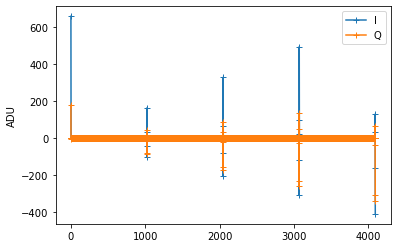

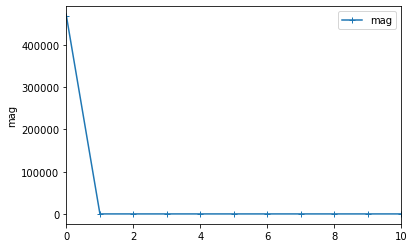

In [26]:
# parsing for ACCUM
q0 = (np.int32(wide_data[1::4])).astype("float")
i0 = (np.int32(wide_data[0::4])).astype("float")
q1 = (np.int32(wide_data[3::4])).astype("float")
i1 = (np.int32(wide_data[2::4])).astype("float")

I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = q0
Q3[1::2] = q1
I3[0::2] = i0
I3[1::2] = i1
plt.figure(figsize=(13,7))
c = slice(0,4096)

plt.figure()
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.xlim(0,10)
plt.ylabel("mag")
plt.legend()

In [ ]:
# DDS shift debug loop
dds_shift=firmware.gpio3.axi_gpio_0 # DDS SHIFT offset = 0x00, 0x08 is open
for step in range(512):
    dds_shift.write(0x00,step) # WRITING TO DDS SHIFT 
    sleep(.01)
    ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")
    Iddc_f = ddc_IQ_dat[0::2].astype("float")/2**13
    Qddc_f = ddc_IQ_dat[1::2].astype("float")/2**13
    IQddc=abs(Iddc_f+1j*Qddc_f)
    peak=IQddc[np.argmax(IQddc[:1024])]
    print(step, peak)